In [95]:
import json
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from typing import Literal

RESULTS_JSON_PATH = Path(os.getcwd()).parent.parent.parent / "experiments" / "results.json"

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 18          # Base font size
plt.rcParams['axes.titlesize'] = 22     # Axes title
plt.rcParams['axes.labelsize'] = 18     # X and Y labels
plt.rcParams['xtick.labelsize'] = 17    # X tick labels
plt.rcParams['ytick.labelsize'] = 17    # Y tick labels
plt.rcParams['legend.fontsize'] = 18    # Legend
plt.rcParams['figure.titlesize'] = 30   # Figure title (suptitle)

In [96]:
VOTE_METHOD = "max_vote_window"
SCORE_TYPE = "kaggle_private"
MODEL_CATEGORIES = ["Baseline", "XGBoost", "SVM", "CNN", "GRU", "TCN", "Other", "Ensemble", "Other Models"]

HIGHLIGHT_IDENTIFIER = None
HIGHLIGHT_IDENTIFIER = "cbramod_transformer"
HIGHLIGHT_IDENTIFIER_NAME = "CBraMod"


PLOT_TITLE = "Fine-tuned CBraMod Transformer in Comparison to Other Models"

In [97]:
# Load the data
with open(RESULTS_JSON_PATH, 'r') as f:
    data = json.load(f)

def categorize_model(identifier: str) -> str:
    """Categorize models based on their identifier."""
    if 'baseline' in identifier:
        return 'Baseline'
    elif 'best' in identifier:
        return 'Other Models'
    elif 'ensemble' in identifier:
        return 'Ensemble'
    elif 'xgboost' in identifier:
        return 'XGBoost'
    elif 'svm' in identifier:
        return 'SVM'
    elif 'cnn' in identifier:
        return 'CNN'
    elif 'gru' in identifier:
        return 'GRU'
    elif 'tcn' in identifier:
        return 'TCN'
    else:
        return 'Other'

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), '#808080', '#808080', '#808080']


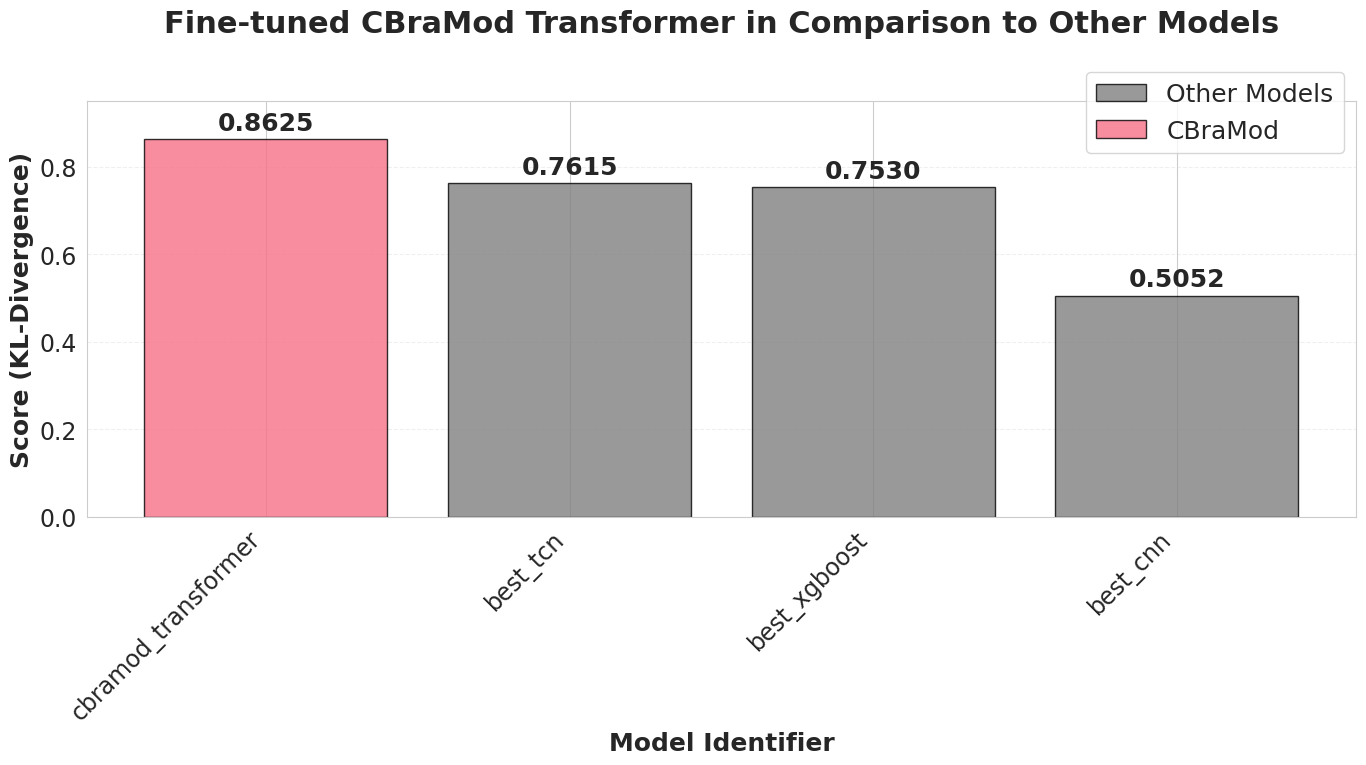

In [102]:
def visualize_results(
    vote_method: Literal['max_vote_window', 'sum_and_normalize'],
    score_type: Literal['cv', 'kaggle_private', 'kaggle_public'],
    model_categories: list,
    highlight_identifier: str | None = None
):
    """
    Visualize model results for a specific vote method and score type.
    
    Parameters:
    -----------
    vote_method : str
        Either 'max_vote_window' or 'sum_and_normalize'
    score_type : str
        Either 'cv', 'kaggle_private', or 'kaggle_public'
    """   

    # Filter data by vote method
    filtered_data = [
        entry for entry in data 
        if entry['data_preparation_vote_method'] == vote_method
    ]
    
    # Add highlight entry if specified
    if highlight_identifier:
        highlight_entry = next(
            (entry for entry in data 
             if entry['identifier'] == highlight_identifier and 
             entry['data_preparation_vote_method'] == vote_method),
            None
        )
        if highlight_entry:
            filtered_data.append(highlight_entry)

    # Create DataFrame
    df = pd.DataFrame([
        {
            'identifier': entry['identifier'],
            'category': categorize_model(entry['identifier']),
            'score': entry['scores'][score_type],
            'is_highlight': entry['identifier'] == highlight_identifier
        }
        for entry in filtered_data
    ])
    # Further filter by model categories
    df = df[df['category'].isin(model_categories) | df['is_highlight']]

    # Distinct by identifier
    df = df.drop_duplicates(subset=['identifier'])

    # Sort by score (lower is better)
    df = df.sort_values('score', ascending=False)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(14, max(8, len(df) * 0.4)))
    
    # Generate colors dynamically for each category
    categories = df[~df['is_highlight']]['category'].unique()  # Exclude highlight from palette
    palette = sns.color_palette("husl", n_colors=len(categories))
    category_colors = dict(zip(categories, palette))

    # Create color list based on categories, with gray for highlighted identifier
    colors = [
        (0.9677975592919913, 0.44127456009157356, 0.5358103155058701) if row['is_highlight'] 
        else '#808080'
        for _, row in df.iterrows()
    ]
    print(colors)
    # Create vertical bar chart
    bars = ax.bar(range(len(df)), df['score'], color=colors, alpha=0.8, edgecolor='black')

    # Customize the plot
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df['identifier'], rotation=45, ha='right')
    ax.set_ylabel('Score (KL-Divergence)', fontweight='bold')
    ax.set_xlabel('Model Identifier', fontweight='bold')
    ax.set_title(
        PLOT_TITLE,
        fontweight='bold',
        pad=50
    )
    ax.set_ylim(0, df['score'].max() * 1.1)
    
    # Add score values on top of the bars
    for i, (score, bar) in enumerate(zip(df['score'], bars)):
        ax.text(bar.get_x() + bar.get_width()/2, score + 0.01, 
                f'{score:.4f}', 
                ha='center', va='bottom', fontweight='bold')
    
    # Add legend
    if len(model_categories) > 1 or highlight_identifier:
        legend_elements = [
            Patch(facecolor='#808080', edgecolor='black', label=category, alpha=0.8)
            for category, color in category_colors.items()
        ]
        if highlight_identifier:
            legend_elements.append(
                Patch(facecolor=(0.9677975592919913, 0.44127456009157356, 0.5358103155058701), edgecolor='black', label=HIGHLIGHT_IDENTIFIER_NAME, alpha=0.8)
            )
        ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1, 1.1))
    
    # Add grid
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    plt.show()

    fig.savefig(f'model_comparison_{vote_method}_{score_type}.svg')

df_results = visualize_results(
    vote_method=VOTE_METHOD,
    score_type=SCORE_TYPE,
    model_categories=MODEL_CATEGORIES,
    highlight_identifier=HIGHLIGHT_IDENTIFIER,
)